In [1]:
!pip install gdown

In [2]:
import gdown
import zipfile
file_id = "1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ"
output = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet = False)

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
  zip_ref.extractall("/content/dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=414d338e-b352-47d5-98f5-32e4038999bf
To: /content/dataset.zip
100%|██████████| 1.13G/1.13G [00:14<00:00, 79.2MB/s]


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

In [4]:
np.random.seed(42)

In [5]:
class LensingDataset(Dataset):
  def __init__(self, data_paths, labels, transform = None):
    self.data_paths = data_paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.data_paths)

  def __getitem__(self, idx):
    img = np.load(self.data_paths[idx])
    if img.shape != (1, 150, 150):
      img = img.reshape(1, 150, 150)

    img_tensor = torch.from_numpy(img).float()

    if self.transform:
      img_tensor = self.transform(img_tensor)

    if img_tensor.shape[0] == 1:
      img_tensor = img_tensor.repeat(3, 1, 1)

    return img_tensor, self.labels[idx]

In [6]:
def check_data_integrity(data_loader):
    try:
        inputs, labels = next(iter(data_loader))
        print(f"Data check - Input shape: {inputs.shape}, Labels shape: {labels.shape}")
        print(f"Data check - Input dtype: {inputs.dtype}, Labels dtype: {labels.dtype}")
        print(f"Data check - Labels unique values: {torch.unique(labels)}")
        return True
    except Exception as e:
        print(f"Data integrity check failed: {e}")
        return False

In [7]:
def load_data(base_dir):
  class_folders = ['no', 'sphere', 'vort']
  data_paths = []
  labels = []

  for class_idx, folder in enumerate(class_folders):
    folder_path = os.path.join(base_dir, folder)

    if not os.path.exists(folder_path):
      print(f"Warning: Folder {folder_path} does not exist")
      continue

    npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    file_list = [os.path.join(folder_path, f) for f in npy_files]
    data_paths.extend(file_list)
    labels.extend([class_idx] * len(file_list))

  unique_labels, counts = np.unique(labels, return_counts=True)
  print("Class distribution:")
  for label, count in zip(unique_labels, counts):
    print(f"  Class {label}: {count} samples")
  return data_paths, labels

In [8]:
def get_model(model_name, num_classes=3):
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported")

    return model

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs = 25, device = "cuda"):
  best_model_wts = None
  best_auc = 0.0
  history = {
      'train_loss' : [], 'val_loss' : [],
      'train_acc' : [], 'val_acc' : []
  }
  if not check_data_integrity(train_loader) or not check_data_integrity(val_loader):
    print("Data integrity check failed. Aborting training.")
    return model, history


  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    model.train()
    train_loss = 0.0
    train_corrects = 0

    for inputs, labels in tqdm(train_loader, desc = "Training"):
      try:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

      except Exception as e:
        print(f"Error during training: {e}")
        continue

    if scheduler:
      scheduler.step()


    train_loss += loss.item() * inputs.size(0)
    train_corrects += torch.sum(preds == labels.data)

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_acc = float(train_corrects) / len(train_loader.dataset)

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')


    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_labels = []
    all_probs = []

    for inputs, labels in tqdm(val_loader, desc="Validation"):
      try:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          probs = nn.Softmax(dim = 1)(outputs)

        val_loss += loss.item() * inputs.size(0)
        val_corrects += torch.sum(preds == labels.data)

        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

      except Exception as e:
        print(f"Error during validation: {e}")
        continue

    if len(all_labels) == 0 or len(all_probs) == 0:
      print("No valid validation batches. Skipping ROC calculation.")
      continue

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = float(val_corrects) / len(val_loader.dataset)

    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    try:
      all_labels = np.concatenate(all_labels)
      all_probs = np.concatenate(all_probs)

      unique_labels = np.unique(all_labels)

      mean_auc = 0
      class_count = 0

      for class_idx in range(3):
        if class_idx not in unique_labels and len(unique_labels) < 3:
          print(f"Warning: Class {class_idx} not in validation set")
          continue

        binary_labels = (all_labels == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, class_idx])
        roc_auc = auc(fpr, tpr)
        mean_auc += roc_auc
        class_count += 1

      mean_auc /= max(1, class_count)
      print(f'Mean AUC: {mean_auc:.4f}')

      if mean_auc > best_auc:
        best_auc = mean_auc
        best_model_wts = model.state_dict().copy()

    except Exception as e:
      print(f"Error calculating ROC/AUC: {e}")
      continue

    print(f'Best validation AUC: {best_auc:.4f}')

    if best_model_wts is not None:
      model.load_state_dict(best_model_wts)
  return model, history

In [19]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            try:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                probs = nn.Softmax(dim=1)(outputs)

                all_labels.append(labels.cpu().numpy())
                all_probs.append(probs.cpu().numpy())
                all_preds.append(preds.cpu().numpy())

            except Exception as e:
                print(f"Error during evaluation: {e}")
                continue

    if not all_labels or not all_probs or not all_preds:
        print("No valid test batches. Cannot evaluate model.")
        return 0, 0, None

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)

    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)
    print(f'Test Accuracy: {accuracy:.4f}')

    # Plot ROC curves and calculate AUC
    plt.figure(figsize=(10, 8))

    class_names = ['No Substructure', 'Sphere Substructure', 'Vortex Substructure']
    colors = ['blue', 'red', 'green']

    mean_auc = 0
    class_count = 0

    # Get unique classes in test set
    unique_labels = np.unique(all_labels)

    for i, class_name in enumerate(class_names):
        # Skip classes that don't exist in the test set
        if i not in unique_labels and len(unique_labels) < 3:
            print(f"Warning: Class {i} not in test set")
            continue

        try:
            binary_labels = (all_labels == i).astype(int)
            fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            mean_auc += roc_auc
            class_count += 1

            plt.plot(fpr, tpr, color=colors[i], lw=2,
                    label=f'{class_name} (AUC = {roc_auc:.3f})')
        except Exception as e:
            print(f"Error calculating ROC for class {i}: {e}")
            continue

    mean_auc /= max(1, class_count)  # Avoid division by zero

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (Mean AUC = {mean_auc:.3f})')
    plt.legend(loc="lower right")
    plt.grid(True)

    return accuracy, mean_auc, plt

In [20]:
def main(base_dir, model_name='efficientnet_b0', batch_size=16, num_epochs=10):
    # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Print CUDA information for debugging
        print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
        print(f"CUDA device count: {torch.cuda.device_count()}")
        print(f"CUDA version: {torch.version.cuda}")
    else:
        device = torch.device("cpu")
        print("CUDA not available, using CPU")

    # Load data
    try:
        data_paths, labels = load_data(base_dir)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, 0, 0

    # Split data
    try:
        train_paths, test_paths, train_labels, test_labels = train_test_split(
            data_paths, labels, test_size=0.2, random_state=42, stratify=labels
        )

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
        )
    except Exception as e:
        print(f"Error splitting data: {e}")
        return None, 0, 0

    print(f"Train samples: {len(train_paths)}")
    print(f"Validation samples: {len(val_paths)}")
    print(f"Test samples: {len(test_paths)}")

    # Create datasets and dataloaders
    try:
        train_dataset = LensingDataset(train_paths, train_labels)
        val_dataset = LensingDataset(val_paths, val_labels)
        test_dataset = LensingDataset(test_paths, test_labels)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Check if dataloaders work
        check_data_integrity(train_loader)
    except Exception as e:
        print(f"Error creating datasets/dataloaders: {e}")
        return None, 0, 0

    # Initialize model
    try:
        model = get_model(model_name)
        model = model.to(device)
        print(f"Model initialized: {model_name}")
    except Exception as e:
        print(f"Error initializing model: {e}")
        return None, 0, 0

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train model
    try:
        model, history = train_model(
            model, train_loader, val_loader, criterion, optimizer,
            scheduler, num_epochs=num_epochs, device=device
        )
    except Exception as e:
        print(f"Error during training: {e}")
        return model, 0, 0

    # Evaluate model
    try:
        accuracy, mean_auc, plt_roc = evaluate_model(model, test_loader, device=device)
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return model, 0, 0

    # Save model to Google Drive
    try:
        model_save_path = os.path.join('/content/drive/MyDrive', f'{model_name}_lensing_classifier.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

    # Plot training history
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/training_history.png')

        # Save ROC curve
        if plt_roc:
            plt_roc.savefig('/content/drive/MyDrive/roc_curve.png')
    except Exception as e:
        print(f"Error plotting results: {e}")

    print(f"Final test accuracy: {accuracy:.4f}")
    print(f"Final mean AUC: {mean_auc:.4f}")

    return model, accuracy, mean_auc


In [21]:
def compare_models(base_dir, models_to_try=['resnet50', 'efficientnet_b0', 'densenet121'], epochs=10):
    results = {}

    for model_name in models_to_try:
        print(f"\n\n{'='*50}")
        print(f"Training model: {model_name}")
        print(f"{'='*50}\n")

        try:
            model, accuracy, mean_auc = main(base_dir, model_name=model_name, num_epochs=epochs)
            if model is not None:
                results[model_name] = {'accuracy': accuracy, 'auc': mean_auc}
            else:
                print(f"Training failed for {model_name}")
        except Exception as e:
            print(f"Error in model comparison for {model_name}: {e}")

    if not results:
        print("No models were successfully trained")
        return {}

    # Print comparison results
    print("\nModel Comparison Results:")
    print(f"{'Model':<15} {'Accuracy':<10} {'Mean AUC':<10}")
    print('-' * 35)

    for model_name, metrics in results.items():
        print(f"{model_name:<15} {metrics['accuracy']:.4f}     {metrics['auc']:.4f}")

    # Find best model
    best_model = max(results.items(), key=lambda x: x[1]['auc'])
    print(f"\nBest model by AUC: {best_model[0]} with AUC = {best_model[1]['auc']:.4f}")

    # Save results to a text file
    try:
        with open('/content/drive/MyDrive/model_comparison_results.txt', 'w') as f:
            f.write("Model Comparison Results:\n")
            f.write(f"{'Model':<15} {'Accuracy':<10} {'Mean AUC':<10}\n")
            f.write('-' * 35 + '\n')

            for model_name, metrics in results.items():
                f.write(f"{model_name:<15} {metrics['accuracy']:.4f}     {metrics['auc']:.4f}\n")

            f.write(f"\nBest model by AUC: {best_model[0]} with AUC = {best_model[1]['auc']:.4f}\n")
    except Exception as e:
        print(f"Error saving results: {e}")

    return results

In [22]:
data_dir = "/content/dataset/dataset/train"

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using CUDA: Tesla T4
CUDA device count: 1
CUDA version: 12.4
Class distribution:
  Class 0: 10000 samples
  Class 1: 10000 samples
  Class 2: 10000 samples
Train samples: 19200
Validation samples: 4800
Test samples: 6000
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Model initialized: efficientnet_b0
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Epoch 1/10
----------


Training: 100%|██████████| 1200/1200 [01:14<00:00, 16.07it/s]


Train Loss: 0.0006 Acc: 0.0005


Validation: 100%|██████████| 300/300 [00:15<00:00, 19.38it/s]


Val Loss: 0.8092 Acc: 0.6310
Mean AUC: 0.8201
Best validation AUC: 0.8201
Epoch 2/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.52it/s]


Train Loss: 0.0007 Acc: 0.0005


Validation: 100%|██████████| 300/300 [00:05<00:00, 57.54it/s]


Val Loss: 0.6029 Acc: 0.7608
Mean AUC: 0.9168
Best validation AUC: 0.9168
Epoch 3/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.51it/s]


Train Loss: 0.0005 Acc: 0.0007


Validation: 100%|██████████| 300/300 [00:04<00:00, 60.23it/s]


Val Loss: 0.3857 Acc: 0.8435
Mean AUC: 0.9587
Best validation AUC: 0.9587
Epoch 4/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.49it/s]


Train Loss: 0.0006 Acc: 0.0005


Validation: 100%|██████████| 300/300 [00:05<00:00, 59.53it/s]


Val Loss: 0.3235 Acc: 0.8762
Mean AUC: 0.9699
Best validation AUC: 0.9699
Epoch 5/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.54it/s]


Train Loss: 0.0001 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:04<00:00, 60.99it/s]


Val Loss: 0.3389 Acc: 0.8702
Mean AUC: 0.9697
Best validation AUC: 0.9699
Epoch 6/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.44it/s]


Train Loss: 0.0003 Acc: 0.0007


Validation: 100%|██████████| 300/300 [00:04<00:00, 60.36it/s]


Val Loss: 0.2999 Acc: 0.8931
Mean AUC: 0.9755
Best validation AUC: 0.9755
Epoch 7/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.45it/s]


Train Loss: 0.0001 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:04<00:00, 60.07it/s]


Val Loss: 0.2799 Acc: 0.9010
Mean AUC: 0.9757
Best validation AUC: 0.9757
Epoch 8/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.66it/s]


Train Loss: 0.0001 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:05<00:00, 55.34it/s]


Val Loss: 0.2332 Acc: 0.9185
Mean AUC: 0.9856
Best validation AUC: 0.9856
Epoch 9/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.65it/s]


Train Loss: 0.0000 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:05<00:00, 53.37it/s]


Val Loss: 0.2263 Acc: 0.9219
Mean AUC: 0.9856
Best validation AUC: 0.9856
Epoch 10/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.65it/s]


Train Loss: 0.0000 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:05<00:00, 52.76it/s]


Val Loss: 0.2383 Acc: 0.9254
Mean AUC: 0.9855
Best validation AUC: 0.9856


Testing: 100%|██████████| 375/375 [00:15<00:00, 23.93it/s]


Test Accuracy: 0.9223
Model saved to /content/drive/MyDrive/efficientnet_b0_lensing_classifier.pth
Final test accuracy: 0.9223
Final mean AUC: 0.9856


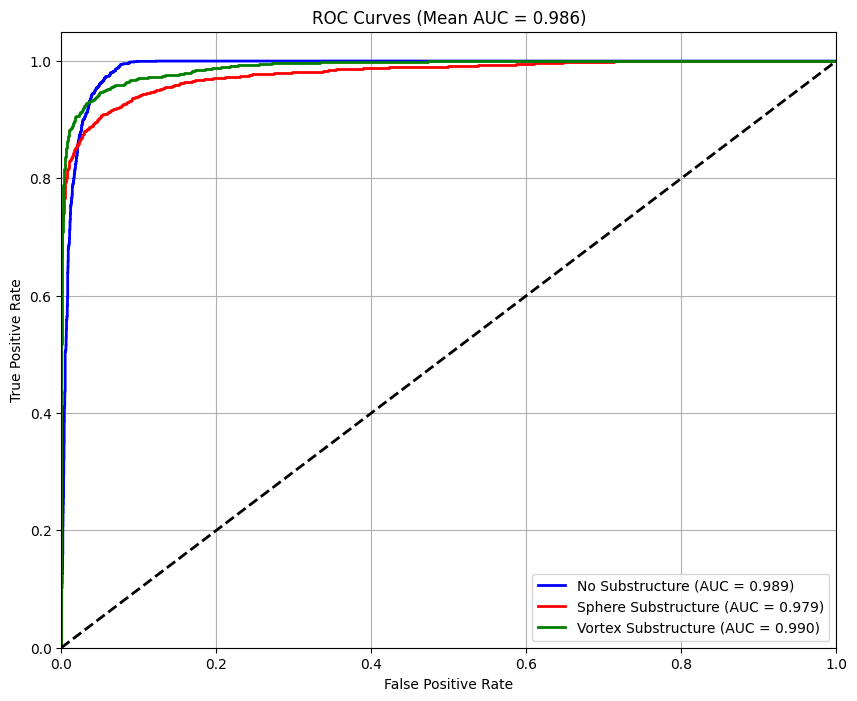

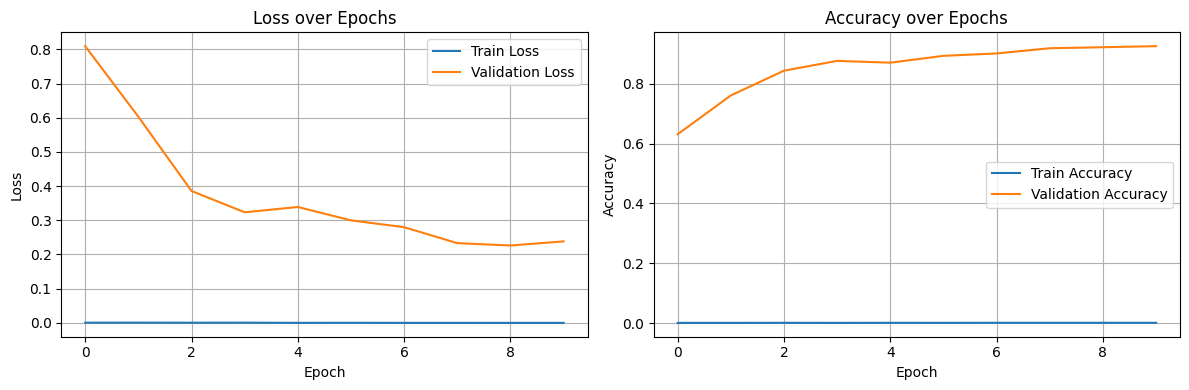

In [23]:
model, accuracy, mean_auc = main(data_dir, model_name='efficientnet_b0', batch_size=16, num_epochs=10)



Training model: resnet50

Using CUDA: Tesla T4
CUDA device count: 1
CUDA version: 12.4
Class distribution:
  Class 0: 10000 samples
  Class 1: 10000 samples
  Class 2: 10000 samples
Train samples: 19200
Validation samples: 4800
Test samples: 6000
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Model initialized: resnet50
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Epoch 1/10
----------


Training: 100%|██████████| 1200/1200 [01:52<00:00, 10.70it/s]


Train Loss: 0.0009 Acc: 0.0004


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.76it/s]


Val Loss: 1.1029 Acc: 0.3310
Mean AUC: 0.5027
Best validation AUC: 0.5027
Epoch 2/10
----------


Training: 100%|██████████| 1200/1200 [01:51<00:00, 10.77it/s]


Train Loss: 0.0009 Acc: 0.0004


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.33it/s]


Val Loss: 1.0991 Acc: 0.3333
Mean AUC: 0.5045
Best validation AUC: 0.5045
Epoch 3/10
----------


Training: 100%|██████████| 1200/1200 [01:51<00:00, 10.75it/s]


Train Loss: 0.0009 Acc: 0.0002


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.34it/s]


Val Loss: 1.0987 Acc: 0.3356
Mean AUC: 0.5047
Best validation AUC: 0.5047
Epoch 4/10
----------


Training: 100%|██████████| 1200/1200 [01:51<00:00, 10.77it/s]


Train Loss: 0.0009 Acc: 0.0002


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.71it/s]


Val Loss: 1.1028 Acc: 0.3233
Mean AUC: 0.4941
Best validation AUC: 0.5047
Epoch 5/10
----------


Training: 100%|██████████| 1200/1200 [01:50<00:00, 10.82it/s]


Train Loss: 0.0009 Acc: 0.0001


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.71it/s]


Val Loss: 1.1056 Acc: 0.3381
Mean AUC: 0.4925
Best validation AUC: 0.5047
Epoch 6/10
----------


Training: 100%|██████████| 1200/1200 [01:50<00:00, 10.82it/s]


Train Loss: 0.0009 Acc: 0.0005


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.56it/s]


Val Loss: 1.0983 Acc: 0.3471
Mean AUC: 0.5148
Best validation AUC: 0.5148
Epoch 7/10
----------


Training: 100%|██████████| 1200/1200 [01:51<00:00, 10.79it/s]


Train Loss: 0.0009 Acc: 0.0002


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.84it/s]


Val Loss: 1.0988 Acc: 0.3281
Mean AUC: 0.4996
Best validation AUC: 0.5148
Epoch 8/10
----------


Training: 100%|██████████| 1200/1200 [01:51<00:00, 10.78it/s]


Train Loss: 0.0009 Acc: 0.0003


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.63it/s]


Val Loss: 1.0997 Acc: 0.3331
Mean AUC: 0.4945
Best validation AUC: 0.5148
Epoch 9/10
----------


Training: 100%|██████████| 1200/1200 [01:51<00:00, 10.80it/s]


Train Loss: 0.0009 Acc: 0.0003


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.88it/s]


Val Loss: 1.0990 Acc: 0.3346
Mean AUC: 0.4865
Best validation AUC: 0.5148
Epoch 10/10
----------


Training: 100%|██████████| 1200/1200 [01:51<00:00, 10.79it/s]


Train Loss: 0.0009 Acc: 0.0004


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.87it/s]


Val Loss: 1.0988 Acc: 0.3281
Mean AUC: 0.4943
Best validation AUC: 0.5148


Testing: 100%|██████████| 375/375 [00:11<00:00, 31.91it/s]


Test Accuracy: 0.3407
Model saved to /content/drive/MyDrive/resnet50_lensing_classifier.pth
Final test accuracy: 0.3407
Final mean AUC: 0.5092


Training model: efficientnet_b0

Using CUDA: Tesla T4
CUDA device count: 1
CUDA version: 12.4
Class distribution:
  Class 0: 10000 samples
  Class 1: 10000 samples
  Class 2: 10000 samples
Train samples: 19200
Validation samples: 4800
Test samples: 6000
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Model initialized: efficientnet_b0
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.i

Training: 100%|██████████| 1200/1200 [00:59<00:00, 20.22it/s]


Train Loss: 0.0008 Acc: 0.0005


Validation: 100%|██████████| 300/300 [00:05<00:00, 53.72it/s]


Val Loss: 0.8767 Acc: 0.5575
Mean AUC: 0.8040
Best validation AUC: 0.8040
Epoch 2/10
----------


Training: 100%|██████████| 1200/1200 [00:59<00:00, 20.34it/s]


Train Loss: 0.0004 Acc: 0.0007


Validation: 100%|██████████| 300/300 [00:05<00:00, 56.46it/s]


Val Loss: 0.5076 Acc: 0.7950
Mean AUC: 0.9326
Best validation AUC: 0.9326
Epoch 3/10
----------


Training: 100%|██████████| 1200/1200 [00:59<00:00, 20.17it/s]


Train Loss: 0.0005 Acc: 0.0006


Validation: 100%|██████████| 300/300 [00:05<00:00, 56.48it/s]


Val Loss: 0.3957 Acc: 0.8494
Mean AUC: 0.9558
Best validation AUC: 0.9558
Epoch 4/10
----------


Training: 100%|██████████| 1200/1200 [00:59<00:00, 20.22it/s]


Train Loss: 0.0005 Acc: 0.0006


Validation: 100%|██████████| 300/300 [00:05<00:00, 58.30it/s]


Val Loss: 0.3101 Acc: 0.8783
Mean AUC: 0.9717
Best validation AUC: 0.9717
Epoch 5/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.40it/s]


Train Loss: 0.0001 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:04<00:00, 61.00it/s]


Val Loss: 0.3444 Acc: 0.8696
Mean AUC: 0.9738
Best validation AUC: 0.9738
Epoch 6/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.42it/s]


Train Loss: 0.0004 Acc: 0.0007


Validation: 100%|██████████| 300/300 [00:04<00:00, 60.51it/s]


Val Loss: 0.2732 Acc: 0.8969
Mean AUC: 0.9779
Best validation AUC: 0.9779
Epoch 7/10
----------


Training: 100%|██████████| 1200/1200 [00:59<00:00, 20.22it/s]


Train Loss: 0.0003 Acc: 0.0007


Validation: 100%|██████████| 300/300 [00:05<00:00, 59.32it/s]


Val Loss: 0.2608 Acc: 0.9012
Mean AUC: 0.9795
Best validation AUC: 0.9795
Epoch 8/10
----------


Training: 100%|██████████| 1200/1200 [00:59<00:00, 20.25it/s]


Train Loss: 0.0000 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:05<00:00, 59.57it/s]


Val Loss: 0.2266 Acc: 0.9198
Mean AUC: 0.9859
Best validation AUC: 0.9859
Epoch 9/10
----------


Training: 100%|██████████| 1200/1200 [00:59<00:00, 20.34it/s]


Train Loss: 0.0001 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:04<00:00, 62.23it/s]


Val Loss: 0.2285 Acc: 0.9206
Mean AUC: 0.9861
Best validation AUC: 0.9861
Epoch 10/10
----------


Training: 100%|██████████| 1200/1200 [00:58<00:00, 20.63it/s]


Train Loss: 0.0000 Acc: 0.0008


Validation: 100%|██████████| 300/300 [00:05<00:00, 56.92it/s]


Val Loss: 0.2378 Acc: 0.9260
Mean AUC: 0.9862
Best validation AUC: 0.9862


Testing: 100%|██████████| 375/375 [00:06<00:00, 61.41it/s]


Test Accuracy: 0.9267
Model saved to /content/drive/MyDrive/efficientnet_b0_lensing_classifier.pth
Final test accuracy: 0.9267
Final mean AUC: 0.9859


Training model: densenet121

Using CUDA: Tesla T4
CUDA device count: 1
CUDA version: 12.4
Class distribution:
  Class 0: 10000 samples
  Class 1: 10000 samples
  Class 2: 10000 samples
Train samples: 19200
Validation samples: 4800
Test samples: 6000
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 82.4MB/s]


Model initialized: densenet121
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Data check - Input shape: torch.Size([16, 3, 150, 150]), Labels shape: torch.Size([16])
Data check - Input dtype: torch.float32, Labels dtype: torch.int64
Data check - Labels unique values: tensor([0, 1, 2])
Epoch 1/10
----------


Training: 100%|██████████| 1200/1200 [01:47<00:00, 11.20it/s]


Train Loss: 0.0009 Acc: 0.0004


Validation: 100%|██████████| 300/300 [00:09<00:00, 32.55it/s]


Val Loss: 1.1730 Acc: 0.3333
Mean AUC: 0.5079
Best validation AUC: 0.5079
Epoch 2/10
----------


Training: 100%|██████████| 1200/1200 [01:46<00:00, 11.29it/s]


Train Loss: 0.0009 Acc: 0.0004


Validation: 100%|██████████| 300/300 [00:09<00:00, 32.30it/s]


Val Loss: 1.1325 Acc: 0.3317
Mean AUC: 0.5003
Best validation AUC: 0.5079
Epoch 3/10
----------


Training: 100%|██████████| 1200/1200 [01:46<00:00, 11.30it/s]


Train Loss: 0.0009 Acc: 0.0004


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.25it/s]


Val Loss: 1.1644 Acc: 0.3333
Mean AUC: 0.5114
Best validation AUC: 0.5114
Epoch 4/10
----------


Training: 100%|██████████| 1200/1200 [01:46<00:00, 11.26it/s]


Train Loss: 0.0009 Acc: 0.0002


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.10it/s]


Val Loss: 1.1629 Acc: 0.3321
Mean AUC: 0.4953
Best validation AUC: 0.5114
Epoch 5/10
----------


Training: 100%|██████████| 1200/1200 [01:47<00:00, 11.20it/s]


Train Loss: 0.0009 Acc: 0.0003


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.32it/s]


Val Loss: 1.1045 Acc: 0.3333
Mean AUC: 0.4956
Best validation AUC: 0.5114
Epoch 6/10
----------


Training: 100%|██████████| 1200/1200 [01:47<00:00, 11.14it/s]


Train Loss: 0.0009 Acc: 0.0002


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.25it/s]


Val Loss: 6.2354 Acc: 0.3333
Mean AUC: 0.5017
Best validation AUC: 0.5114
Epoch 7/10
----------


Training: 100%|██████████| 1200/1200 [01:46<00:00, 11.22it/s]


Train Loss: 0.0009 Acc: 0.0003


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.24it/s]


Val Loss: 1.1089 Acc: 0.3333
Mean AUC: 0.5062
Best validation AUC: 0.5114
Epoch 8/10
----------


Training: 100%|██████████| 1200/1200 [01:47<00:00, 11.21it/s]


Train Loss: 0.0009 Acc: 0.0001


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.83it/s]


Val Loss: 1.1016 Acc: 0.3358
Mean AUC: 0.5019
Best validation AUC: 0.5114
Epoch 9/10
----------


Training: 100%|██████████| 1200/1200 [01:47<00:00, 11.17it/s]


Train Loss: 0.0009 Acc: 0.0003


Validation: 100%|██████████| 300/300 [00:09<00:00, 31.28it/s]


Val Loss: 1.0985 Acc: 0.3383
Mean AUC: 0.5073
Best validation AUC: 0.5114
Epoch 10/10
----------


Training: 100%|██████████| 1200/1200 [01:47<00:00, 11.12it/s]


Train Loss: 0.0009 Acc: 0.0004


Validation: 100%|██████████| 300/300 [00:09<00:00, 30.72it/s]


Val Loss: 1.0991 Acc: 0.3477
Mean AUC: 0.5026
Best validation AUC: 0.5114


Testing: 100%|██████████| 375/375 [00:12<00:00, 31.12it/s]


Test Accuracy: 0.3388
Model saved to /content/drive/MyDrive/densenet121_lensing_classifier.pth
Final test accuracy: 0.3388
Final mean AUC: 0.5093

Model Comparison Results:
Model           Accuracy   Mean AUC  
-----------------------------------
resnet50        0.3407     0.5092
efficientnet_b0 0.9267     0.9859
densenet121     0.3388     0.5093

Best model by AUC: efficientnet_b0 with AUC = 0.9859


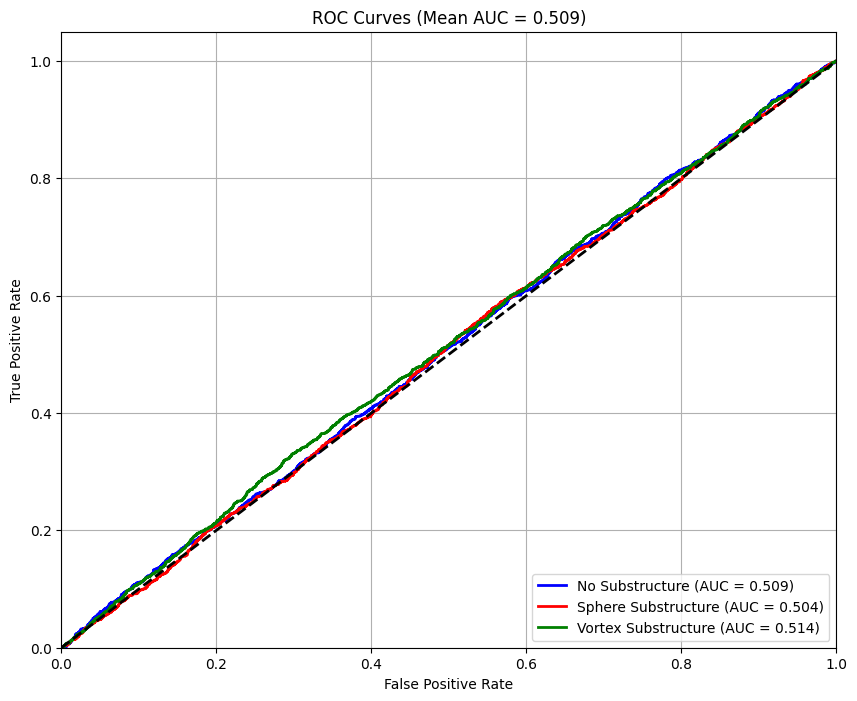

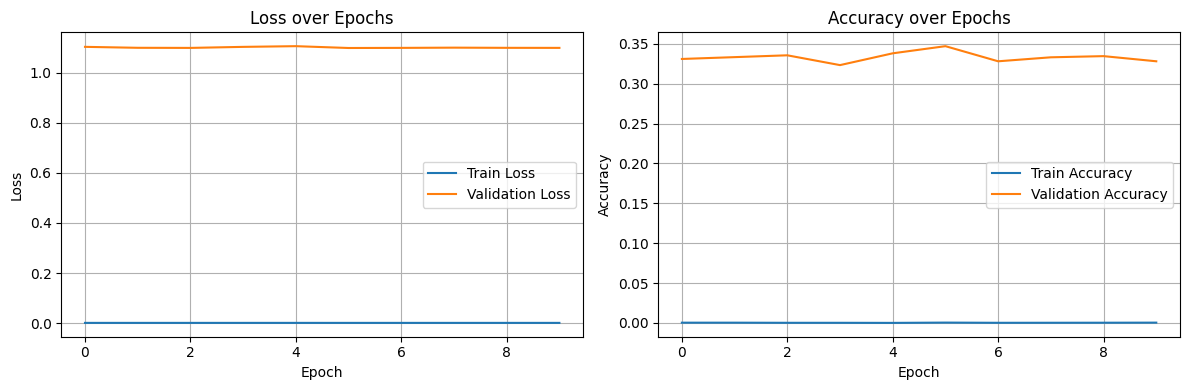

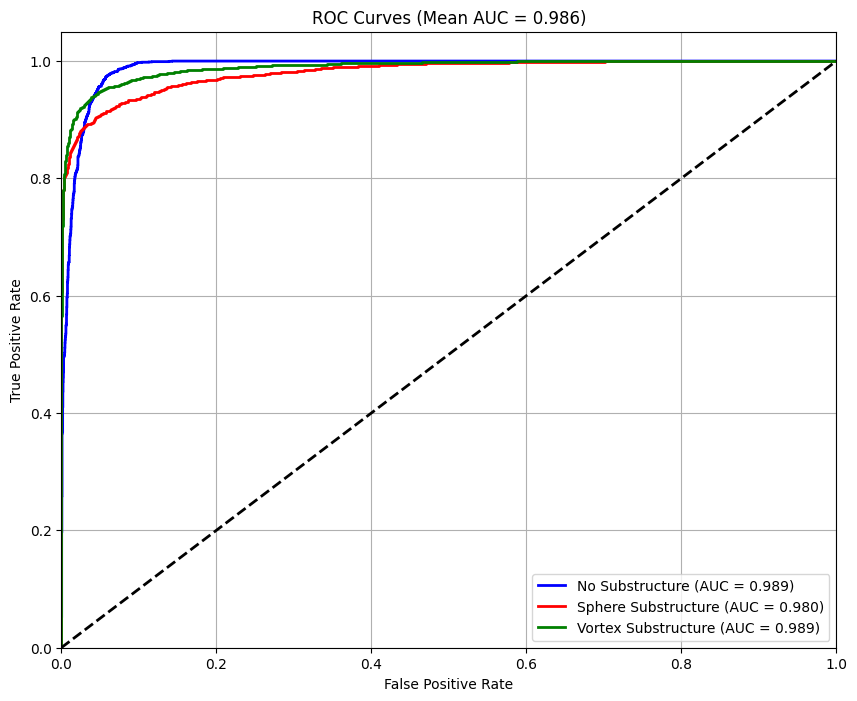

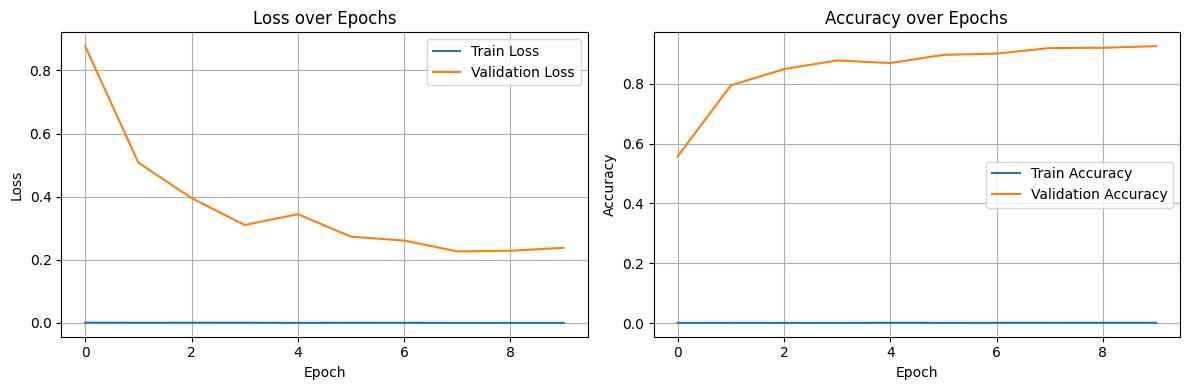

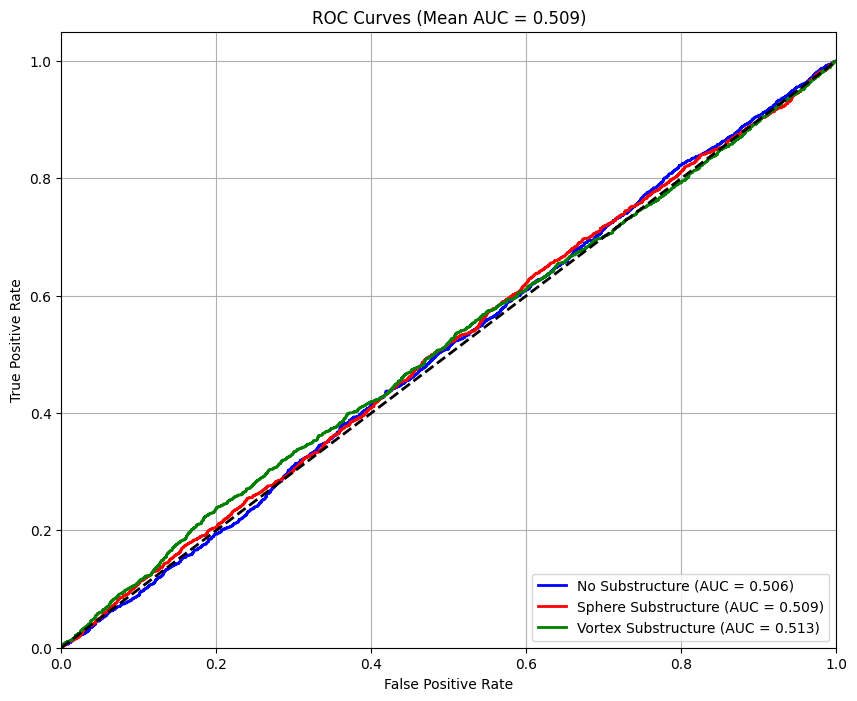

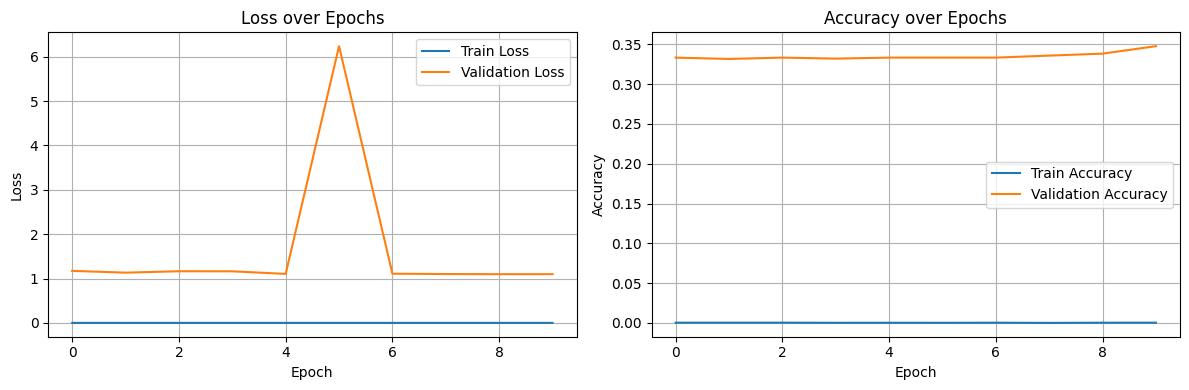

In [24]:
results = compare_models(data_dir, models_to_try=['resnet50', 'efficientnet_b0', 'densenet121'], epochs=10)